# Semantics Comparison

In [57]:
import random
import pandas as pd
import numpy as np
import pycuda.autoprimaryctx
import pycuda.gpuarray as garray
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib as mpl
from example_model_and_params import *

In [58]:
from matplotlib.gridspec import GridSpec

## LimitCycle Mountain of CSN for each Channel

### Limit Cycle Simulations

In [59]:
inp_current = np.arange(150).astype(float)
inp_current_g = garray.to_gpu(np.ascontiguousarray(np.repeat(inp_current[:,None], int(5//1e-5), axis=-1).T))
t = np.arange(len(inp_current_g))*1e-5
nn_csn = Network()
csn_inp = nn_csn.input(num=len(inp_current))
csn_neuron_0 = nn_csn.add(NoisyConnorStevens, num=len(inp_current), sigma=0., name='CSN0')
csn_neuron_1 = nn_csn.add(NoisyConnorStevens, num=len(inp_current), sigma=0.0014/np.sqrt(1e-5), name='CSN1')
csn_neuron_0(I=csn_inp)
csn_neuron_1(I=csn_inp)
nn_csn.compile()
csn_neuron_0.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(inp_current_g)
nn_csn.run(1e-5, verbose=True)

  0%|          | 0/499999 [00:00<?, ?it/s]

In [63]:
from matplotlib.gridspec import GridSpec

In [192]:
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()

<ipython-input-198-b3967e6e8f45>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set(


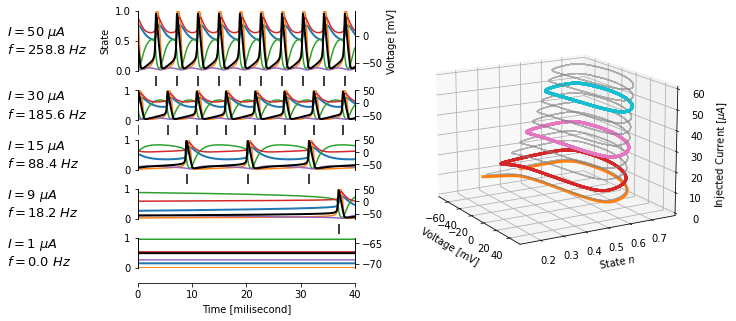

In [198]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
I_plot = [1, 9, 15, 30, 50]
gs = GridSpec(len(I_plot)*2,2, figure=fig, width_ratios=[1.5,2], height_ratios=[6,1]+[3,1]*(len(I_plot)-1))
ax_v = [fig.add_subplot(gs[-(i*2+2),0]) for i in range(len(I_plot))]
ax_spike = [fig.add_subplot(gs[-(i*2+1),0]) for i in range(len(I_plot))]
ax_lc = fig.add_subplot(gs[:,1], projection='3d')

mask_start, mask_end = 4.81, 4.85
t_mask = np.logical_and(t>mask_start, t<mask_end)
for I, ax, ax2 in zip(I_plot, ax_v, ax_spike):
    v, n, m, h, a, b, spike = (
        csn_neuron_0.recorder.v, csn_neuron_0.recorder.n, 
        csn_neuron_0.recorder.m, csn_neuron_0.recorder.h, csn_neuron_0.recorder.a, csn_neuron_0.recorder.b,
        csn_neuron_0.recorder.spike
    )
    idx = np.argmin(np.abs(inp_current-I))
    t_idx = np.where(spike[idx])[0]
    
    ax_v = ax.twinx()
    ax.plot(t[t_mask], n[idx, t_mask], zorder=1, lw=2)
    ax.plot(t[t_mask], m[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], h[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], a[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], b[idx, t_mask], zorder=1)
    ax_v.plot(t[t_mask], v[idx, t_mask], c='k', zorder=100, lw=2)
    
    ax2.scatter(t[t_idx], np.ones(len(t_idx)), marker='|', color='k', s=100)
    if I != I_plot[0]:
        ax2.set(xticklabels=[], xticks=[])
        ax2.spines['bottom'].set_visible(False)
    else:
        ax2.set(
            xticklabels=np.linspace(0, 1000*(mask_end-mask_start), 5).astype(int), 
            xticks=np.linspace(mask_start, mask_end, 5), 
            xlabel='Time [milisecond]'
        )
    if I == I_plot[-1]:
        ax.set(ylabel='State')
        ax_v.set(ylabel='Voltage [mV]')
    ax_v.set(xticklabels=[], xlim=[mask_start, mask_end], xticks=[])
    ax.set(ylim=[0, 1.], xticks=[])
    ax2.set(xlim=[mask_start, mask_end], yticks=[])
    ax_v.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax_v.spines['bottom'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.text(
        -.6, .5, 
        "$I={:d} ~ \mu A$\n$f={:.1f} ~ Hz$".format(I, spike[idx].sum()/5), 
        fontsize=13,
        verticalalignment='center',
        transform=ax.transAxes
    )
    
    

for n, I, spikes0, spikes1 in zip(
    np.arange(len(inp_current)),
    inp_current,
    csn_neuron_0.recorder.spike,
    csn_neuron_0.recorder.spike,
):
#     s_idx_0, = np.where(spikes0)
#     s_idx_1, = np.where(spikes1)
#     if not len(s_idx_0) > 2 or not len(s_idx_1) >= 20:
#         continue
    
    if n % 5 != 0 and I not in I_plot or I > 60:
        continue
    # plot 3d comparison of noisy CSN limit cycle and noiseless CSN limit cycle
    # for m, (s1,s2) in enumerate(zip(s_idx_1[-20:], s_idx_1[-19:-1])):
    ax_lc.plot(
        csn_neuron_0.recorder.v[n, t_mask],
        csn_neuron_0.recorder.n[n, t_mask],
        I,
        c='grey' if I not in I_plot else plt.cm.tab10(I/I_plot[-1]), alpha=.6 if I not in I_plot else 1,
        lw=1 if I not in I_plot else 3.
    )
    # if I in I_plot and I in lc_clean:
    #     ax_lc.plot(
    #         lc_clean[I]['v'],
    #         lc_clean[I]['n'],
    #         I,
    #         c='k',
    #         lw=2
    #     )
ax_lc.view_init(azim=-30, elev=15)
ax_lc.set(zlim=[0., 60.], xlabel='Voltage [mV]', ylabel='State $n$', zlabel='Injected Current [$\mu A$]')
fig.savefig('state_lc_state_clean.pdf')

In [64]:
%matplotlib widget
fig = plt.figure(figsize=(10,5))
gs = GridSpec(1,4, figure=fig, width_ratios=[10,10,1,1])
ax_2d = fig.add_subplot(gs[0])
ax_2d_cbar = fig.add_subplot(gs[2])
ax = fig.add_subplot(gs[1], projection='3d', sharex=ax_2d, sharey=ax_2d)#, sharez=ax_2d)
ax_cbar = fig.add_subplot(gs[3])
cs_noisy = plt.cm.get_cmap('plasma', len(inp_current))
cs_noiseless = plt.cm.get_cmap('Greys', len(inp_current))

limitcycles = dict()
for n, I, spikes0, spikes1 in zip(
    np.arange(len(inp_current)),
    inp_current,
    csn_neuron_0.recorder.spike,
    csn_neuron_1.recorder.spike,
):
    s_idx_0, = np.where(spikes0)
    s_idx_1, = np.where(spikes1)
    if not len(s_idx_0) > 2 or not len(s_idx_1) >= 20:
        continue

    limitcycles[I] = {
        var:getattr(csn_neuron_0.recorder, var)[n, s_idx_0[-2]:s_idx_0[-1]] 
        for var in 'v n m h a b'.split()
    }
    
    ax_2d.plot(
        csn_neuron_0.recorder.v[n, s_idx_0[-2]:s_idx_0[-1]],
        csn_neuron_0.recorder.n[n, s_idx_0[-2]:s_idx_0[-1]],
        # I,
        c=cs_noiseless(n),
    )
    
    # plot 3d comparison of noisy CSN limit cycle and noiseless CSN limit cycle
    for m, (s1,s2) in enumerate(zip(s_idx_1[-20:], s_idx_1[-19:-1])):
        ax.plot(
            csn_neuron_1.recorder.v[n, s1:s2],
            csn_neuron_1.recorder.n[n, s1:s2],
            I,
            c=cs_noisy(n), alpha=.4
        )
    ax.plot(
        csn_neuron_0.recorder.v[n, s_idx_0[-2]:s_idx_0[-1]],
        csn_neuron_0.recorder.n[n, s_idx_0[-2]:s_idx_0[-1]],
        I,
        c='k', lw=2
    )
ax.set(
    xlabel='V [mV]', ylabel='n', zlabel='Injected Current [$\mu$A]', 
)
norm = mpl.colors.BoundaryNorm(np.arange(0, len(inp_current)), plt.cm.Greys.N)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.Greys),
             cax=ax_2d_cbar, orientation='vertical')
norm = mpl.colors.BoundaryNorm(np.arange(0, len(inp_current)), plt.cm.plasma.N)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.plasma),
             cax=ax_cbar, orientation='vertical', label='Injected Current [$\mu$A]')
fig.suptitle('''
Comparison of Limit Cycle of ConnorStevens (grey) and 
NoisyConnorStevens (colored) with Resting Spike Rate of 1 Hz
''')

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax_2d.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax_2d.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# fig.savefig('limit_cycle_full_3d.pdf')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Average Noisy Limit Cycles

In [136]:
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 499999 but corresponding boolean dimension is 1749990

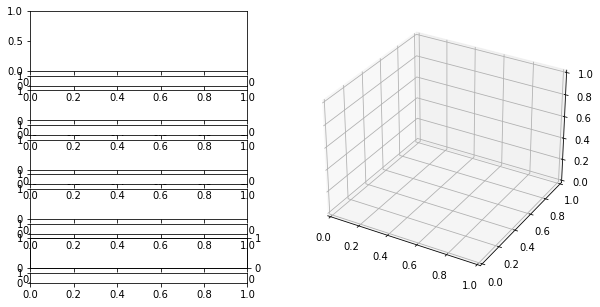

In [316]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
I_plot = [1, 9, 15, 30, 50]
gs = GridSpec(len(I_plot)*2,2, figure=fig, width_ratios=[1.5,2], height_ratios=[6,1]+[3,1]*(len(I_plot)-1))
ax_v = [fig.add_subplot(gs[-(i*2+2),0]) for i in range(len(I_plot))]
ax_spike = [fig.add_subplot(gs[-(i*2+1),0]) for i in range(len(I_plot))]
ax_lc = fig.add_subplot(gs[:,1], projection='3d')

mask_start, mask_end = 4.81, 4.85
t_mask = np.logical_and(t>mask_start, t<mask_end)
for I, ax, ax2 in zip(I_plot, ax_v, ax_spike):
    v, n, m, h, a, b, spike = (
        csn_neuron_1.recorder.v, csn_neuron_1.recorder.n, 
        csn_neuron_1.recorder.m, csn_neuron_1.recorder.h, csn_neuron_1.recorder.a, csn_neuron_1.recorder.b,
        csn_neuron_1.recorder.spike
    )
    idx = np.argmin(np.abs(inp_current-I))
    t_idx = np.where(spike[idx])[0]
    
    ax_v = ax.twinx()
    ax.plot(t[t_mask], n[idx, t_mask], zorder=1, lw=2)
    ax.plot(t[t_mask], m[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], h[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], a[idx, t_mask], zorder=1)
    ax.plot(t[t_mask], b[idx, t_mask], zorder=1)
    ax_v.plot(t[t_mask], v[idx, t_mask], c='k', zorder=100, lw=2)
    
    ax2.scatter(t[t_idx], np.ones(len(t_idx)), marker='|', color='k', s=100)
    if I != I_plot[0]:
        ax2.set(xticklabels=[], xticks=[])
        ax2.spines['bottom'].set_visible(False)
    else:
        ax2.set(
            xticklabels=np.linspace(0, 1000*(mask_end-mask_start), 5).astype(int), 
            xticks=np.linspace(mask_start, mask_end, 5), 
            xlabel='Time [milisecond]'
        )
    if I == I_plot[-1]:
        ax.set(ylabel='State')
        ax_v.set(ylabel='Voltage [mV]')
    ax_v.set(xticklabels=[], xlim=[mask_start, mask_end], xticks=[])
    ax.set(ylim=[0, 1.], xticks=[])
    ax2.set(xlim=[mask_start, mask_end], yticks=[])
    ax_v.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax_v.spines['bottom'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.text(
        -.6, .5, 
        "$I={:d} ~ \mu A$\n$f={:.1f} ~ Hz$".format(I, spike[idx].sum()/5), 
        fontsize=13,
        verticalalignment='center',
        transform=ax.transAxes
    )
    
    

for n, I, spikes0, spikes1 in zip(
    np.arange(len(inp_current)),
    inp_current,
    csn_neuron_0.recorder.spike,
    csn_neuron_1.recorder.spike,
):
#     s_idx_0, = np.where(spikes0)
#     s_idx_1, = np.where(spikes1)
#     if not len(s_idx_0) > 2 or not len(s_idx_1) >= 20:
#         continue
    
    if n % 5 != 0 and I not in I_plot or I > 60:
        continue
    # plot 3d comparison of noisy CSN limit cycle and noiseless CSN limit cycle
    # for m, (s1,s2) in enumerate(zip(s_idx_1[-20:], s_idx_1[-19:-1])):
    if I in I_plot:
        ax_lc.plot(
            csn_neuron_1.recorder.v[n, t_mask],
            csn_neuron_1.recorder.n[n, t_mask],
            I,
            c='grey' if I not in I_plot else plt.cm.tab10(I/I_plot[-1]), alpha=.6,
            lw=1 if I not in I_plot else 3.
        )
        ax_lc.plot(
            lc_noisy[I]['v'].data[~lc_noisy[I]['v'].mask],
            lc_noisy[I]['n'].data[~lc_noisy[I]['n'].mask],
            I,
            c='k',
            lw=2
        )
ax_lc.view_init(azim=-30, elev=15)
ax_lc.set(zlim=[0., 60.], xlabel='Voltage [mV]', ylabel='State $n$', zlabel='Injected Current [$\mu A$]')
# fig.savefig('state_lc_state_noisy.pdf')

(array([251., 514., 604., 427., 158.,  90.,  27.,  14.,   3.,   1.]),
 array([150. , 184.6, 219.2, 253.8, 288.4, 323. , 357.6, 392.2, 426.8,
        461.4, 496. ]),
 <BarContainer object of 10 artists>)

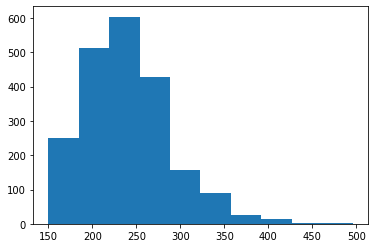

In [106]:
%matplotlib inline
plt.hist(np.diff(s_idx_1))

In [173]:
np.diff(s_idx_1)*dt_long

array([0.00215, 0.0019 , 0.00172, ..., 0.00213, 0.0022 , 0.00211])

In [9]:
lc

NameError: name 'lc' is not defined

In [174]:
T_ref

223

In [175]:
limitcycles_noisy = dict()
for n, I, spikes0, spikes1 in zip(
    np.arange(len(inp_current)),
    inp_current,
    csn_neuron_0.recorder.spike,
    csn_neuron_1.recorder.spike,
):
    s_idx_0, = np.where(spikes0)
    s_idx_1, = np.where(spikes1)
    
    if len(s_idx_0) > 2:
        T_ref = dt_long*(s_idx_0[-1]-s_idx_0[-2])
    else:
        spike_rate = len(s_idx_1) / 5
        T_ref = 1 / spike_rate
    best_lcs = np.argsort(np.abs(np.diff(s_idx_1)*dt_long-T_ref))[:5]
    
    V_all = np.full((len(best_lcs), int(np.diff(s_idx_1).max())), np.nan)
    n_all = np.full((len(best_lcs), int(np.diff(s_idx_1).max())), np.nan)
    
    for m,i in enumerate(best_lcs):
        start, stop = s_idx_1[i], s_idx_1[i+1]
        _v = csn_neuron_1.recorder.v[n, start:stop]
        _n = csn_neuron_1.recorder.n[n, start:stop]
        V_all[m, :len(_v)] = _v
        n_all[m, :len(_n)] = _n
    V_all = np.ma.masked_array(V_all, np.isnan(V_all))
    n_all = np.ma.masked_array(n_all, np.isnan(V_all))
    limitcycles_noisy[I] = dict(v=V_all.mean(0),n=n_all.mean(0))

In [150]:
np.savez('lc_full_noisy', limitcycles_noisy)

In [184]:
%matplotlib widget
fig,ax=plt.subplots(1,1,subplot_kw=dict(projection='3d'))
cs = plt.cm.get_cmap('coolwarm', len(limitcycles_noisy))
for n, (I, states) in enumerate(limitcycles_noisy.items()):
    if n%2 == 0:
        continue
    ax.plot(
        states['v'].data[~states['v'].mask],
        states['n'].data[~states['n'].mask],
        np.ones_like(states['v'].data[~states['v'].mask])*I,
        c=cs(n+5)
    )
ax.view_init(azim=-18, elev=31)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.set(zlim=[0,20])
fig.savefig('3d_mountain.pdf')
# # ax.plot_surface(XX, YY, zout.reshape(XX.shape))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Current Estimate for PN and Phase Space

In [286]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]
pn = data['pn_output'][2]
dt = t[1] - t[0]

aff = df_aff.loc['acetone'].values # affinity rate of acetone
aff2 = df_aff.loc['ethyl acetate'].values
dr = 10. # dissociation rate fixed
N_r = len(aff) # N_r: number of receptors

In [253]:
from antennal_lobe.experiments.data import estimate_current, decompose_signal

In [268]:
import typing as tp
from scipy.signal import lfilter, butter, find_peaks
def decompose_signal(
    t, stim, out, rec_rate=1, t_bounds=None, axis=-1, contrast_eps=1.0, ss_window=0.5, clip=True
) -> tp.Tuple["ss", "pk"]:
    dt = t[1] - t[0]
    b, a = butter(5, 15, fs=1 / dt)
    stim_smooth = lfilter(b, a, np.clip(stim, 0, np.inf), axis=axis)
    d_stim = np.diff(stim_smooth, axis=axis, prepend=stim_smooth[:, [0]]) / dt
    contrast_stim = d_stim / (contrast_eps + stim_smooth)
    pos_peaks_contrast = np.sort(
        np.concatenate(
            [
                find_peaks(
                    contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
                find_peaks(
                    -contrast_stim[0], height=2.5, width=100, distance=int(1.7 // dt)
                )[0],
            ]
        )
    )
    pos_peaks_contrast = (pos_peaks_contrast// rec_rate).astype(int)
    ss = np.zeros_like(out)
    ss[:, : pos_peaks_contrast[0]] = 0  # out[:,:pos_peaks_contrast[0]].mean(1)[:,None]
    ss[
        :, pos_peaks_contrast[-1] :
    ] = 0  # out[:,pos_peaks_contrast[-1]:].mean(1)[:,None]
    ss_vals = np.zeros((out.shape[0], len(pos_peaks_contrast) - 1))
    for n, (start_idx, stop_idx) in enumerate(
        zip(pos_peaks_contrast[:-1], pos_peaks_contrast[1:])
    ):
        ss_amp = out[
            :,
            stop_idx
            - int((0.2 + ss_window) // (dt * rec_rate)) : stop_idx
            - int(0.2 // (dt * rec_rate)),
        ].mean(axis=1)
        ss_vals[:, n] = ss_amp
        ss[:, start_idx:stop_idx] = ss_amp[:, None]
    pk = out - ss
    # trim the peak responses
    if clip:
        pk[:, t[::rec_rate]<=11.83] = np.clip(pk[:, t[::rec_rate]<=11.83], 0, np.inf)
        pk[:, t[::rec_rate]>11.83] = np.clip(pk[:, t[::rec_rate]>11.83], -np.inf, 0)

    # add residual back to ss so that we still add up to the overall response
    ss = out - pk

    return pos_peaks_contrast, ss_vals, ss, pk

In [288]:
stim_t = np.arange(len(stim)) * dt
t = np.arange(0, stim_t.max(), 1e-5)

In [269]:
pos_peaks_contrast, ss_vals, ss, pk = decompose_signal(stim_t, stim[None,:], estimate_current(pn, resting=1)[None,:], clip=False)

In [284]:
pk_on = np.clip(pk, 0, np.inf)
pk_off = np.clip(pk, -np.inf, 0)

In [290]:
pn_inp_I = np.interp(t, stim_t, estimate_current(pn, resting=1))
on_I = np.interp(t, stim_t, pk_on[0])
off_I = np.interp(t, stim_t, pk_off[0])
ss_I = np.interp(t, stim_t, ss[0])

In [291]:
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), dt_long)
pn_inp_I_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I.T))
pn_inp_ss_I_g = garray.to_gpu(np.ascontiguousarray(ss_I.T))
pn_inp_on_I_g = garray.to_gpu(np.ascontiguousarray(on_I.T))
pn_inp_off_I_g = garray.to_gpu(np.ascontiguousarray(off_I.T))

In [231]:
N_pn = 10

In [232]:
nn_pn = Network()
csn_inp = nn_pn.input(num=1)
csn_rep = nn_pn.add(Repeat, num=1, rep_size=N_pn)
csn_neuron_0_pn = nn_pn.add(NoisyConnorStevens, num=N_pn, sigma=0)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_0_pn(I=csn_rep.output)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_0_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

In [237]:
n_idx, t_idx =  np.where(csn_neuron_1_pn.recorder.spike)

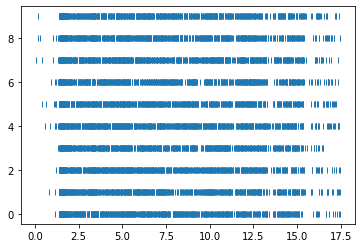

In [238]:
plt.plot(t[t_idx], n_idx, '|')

In [ ]:
csn_neuron_1_pn.recorder.x

In [239]:
from neural.utils import compute_psth

In [249]:
psth, psth_t = compute_psth(csn_neuron_1_pn.recorder.spike, 1e-5, 2e-1, 1e-1)

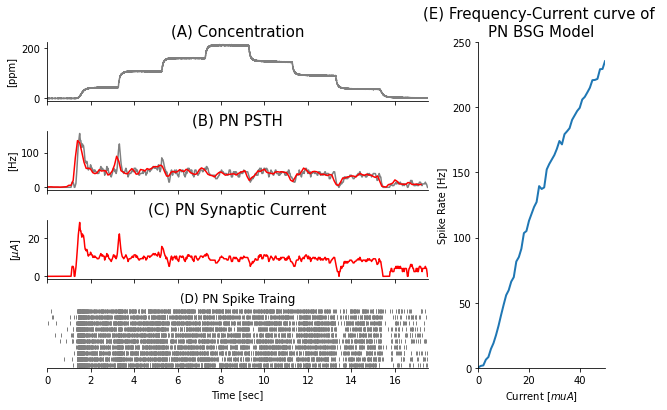

In [ ]:
fig= plt.figure(figsize=(10,6))
gs = GridSpec(4, 2, figure=fig, width_ratios=[3,1], hspace=.5)

axes = [fig.add_subplot(gs[i,0]) for i in range(4)]
ax_fi = fig.add_subplot(gs[:,1])

axes[0].plot(stim_t, stim, c='grey')
axes[1].plot(stim_t, pn, c='grey')
axes[1].plot(psth_t, psth, c='r')
axes[2].plot(t, pn_I, c='r')
n_idx, t_idx = np.where(csn_neuron_1_pn.recorder.spike)
axes[3].plot(t[t_idx], n_idx, '|', c='grey', markersize=4)
axes[0].set(ylabel='[ppm]')
axes[0].set_title('(A) Concentration', fontsize=15)
axes[1].set(ylabel='[Hz]')
axes[1].set_title('(B) PN PSTH', fontsize=15)
axes[2].set(ylabel='[$\mu A$]')
axes[2].set_title('(C) PN Synaptic Current', fontsize=15)
axes[3].set(title='(D) PN Spike Traing', xlabel='Time [sec]')

for i in range(4):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    if i <3:
        axes[i].set(xticklabels=[], xlim=[0, 17.5])
    else:
        axes[i].spines['left'].set_visible(False)
        axes[i].set(xlim=[0, 17.5], xlabel='Time [sec]', yticks=[])


ax_fi.plot(inp_current, csn_neuron_1.recorder.spike.sum(1)/5, lw=2)
ax_fi.set(xlabel='Current [$mu A$]', ylabel='Spike Rate [Hz]',xlim=[0,50], ylim=[0,250])
ax_fi.set_title('(E) Frequency-Current curve of \nPN BSG Model', fontsize=15)
ax_fi.spines['top'].set_visible(False)
ax_fi.spines['right'].set_visible(False)
# fig.tight_layout()
fig.savefig('PN_psth_to_spike_and_back.pdf')

In [292]:
nn_pn = Network()
csn_inp_ss = nn_pn.input(num=1)
csn_rep_ss = nn_pn.add(Repeat, num=1, rep_size=N_pn)
csn_inp_on = nn_pn.input(num=1)
csn_rep_on = nn_pn.add(Repeat, num=1, rep_size=N_pn)
csn_inp_off = nn_pn.input(num=1)
csn_rep_off = nn_pn.add(Repeat, num=1, rep_size=N_pn)

csn_neuron_1_on = nn_pn.add(NoisyConnorStevens, num=N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_neuron_1_off = nn_pn.add(NoisyConnorStevens, num=N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_neuron_1_ss = nn_pn.add(NoisyConnorStevens, num=N_pn, sigma=0.0014/np.sqrt(dt_long))

csn_rep_ss(input=csn_inp_ss)
csn_rep_on(input=csn_inp_on)
csn_rep_off(input=csn_inp_off)

csn_neuron_1_ss(I=csn_rep_ss.output)
csn_neuron_1_on(I=csn_rep_on.output)
csn_neuron_1_off(I=csn_rep_off.output)

nn_pn.compile()
csn_neuron_1_ss.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_on.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_off.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp_ss(pn_inp_ss_I_g)
csn_inp_on(pn_inp_on_I_g)
csn_inp_off(pn_inp_off_I_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

In [222]:
from scipy.signal import convolve

In [224]:
kernel = np.ones(int(.2//1e-5))
kernel /= kernel.sum()
psth = convolve(spike, kernel, mode='same')

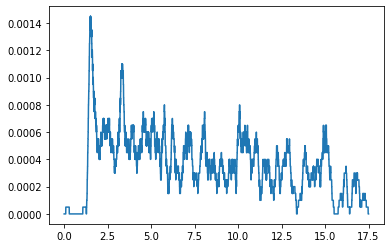

In [225]:
plt.plot(t, psth)

(175000,)

In [97]:
np.savez('lc_full', limitcycles)

In [53]:
from loess.loess_2d import loess_2d
x = []
y = []
z = []
for I, states in limitcycles.items():
    x.append(states['v'][::3])
    y.append(states['n'][::3])
    z.append(np.ones_like(states['n'][::3])*I)

XX,YY = np.meshgrid(np.linspace(-70,50,100), np.linspace(.3,.8,100))
zout, wout = loess_2d(
    np.concatenate(x), np.concatenate(y), np.concatenate(z), 
    xnew=XX.ravel(), ynew=YY.ravel(), degree=3, frac=0.1
)

In [76]:
plt.close('all')
fig,ax=plt.subplots(1,1,subplot_kw=dict(projection='3d'))
cs = plt.cm.get_cmap('Greys', len(limitcycles))
for n, (I, states) in enumerate(limitcycles.items()):
    ax.plot(
        states['v'],
        states['n'],
        np.ones_like(states['n'])*I,
        c=cs(n+5)
    )
fig.savefig('3d_mountain.pdf')
# ax.plot_surface(XX, YY, zout.reshape(XX.shape))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### PN Current Simulations - Acetone

In [3]:
pn_inp_I = np.load('pn_inp.npz')['I']
t = np.load('pn_inp.npz')['t']

In [4]:
N_r = len(pn_inp_I)

In [5]:
N_pn = 5

In [6]:
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), 1e-5)
pn_inp_I_long = np.vstack([np.interp(t_long, t, _I) for _I in pn_inp_I])
pn_inp_I_long_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I_long.T))

In [7]:
nn_pn = Network()
csn_inp = nn_pn.input(num=N_r)
csn_rep = nn_pn.add(Repeat, num=N_r, rep_size=N_pn)
csn_neuron_0_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_0_pn(I=csn_rep.output)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_0_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_long_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

In [8]:
%matplotlib inline
fig,axes = plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
n_idx, t_idx = np.where(csn_neuron_1_pn.recorder.spike)
axes[1].plot(t_long[t_idx], n_idx, '|', markersize=1)
n_idx, t_idx = np.where(csn_neur
                        on_0_pn.recorder.spike)
axes[0].plot(t_long[t_idx], n_idx, '|', markersize=1)

SyntaxError: invalid syntax (<ipython-input-8-9cb27302954c>, line 6)

### PN Trajectory Over LC Mountain - Acetone

In [ ]:
%matplotlib inline
fig,axes = plt.subplots(2,2,figsize=(10,8), sharex=True, gridspec_kw=dict(height_ratios=[1,5]))
axes[0,0].plot(t, stim)
axes[0,1].plot(t, stim)
t_idx, n_idx = np.where(csn_neuron_0_pn.recorder.spike.T)
axes[1,0].plot(t_long[t_idx], n_idx, '|', markersize=2)
t_idx, n_idx = np.where(csn_neuron_1_pn.recorder.spike.T)
axes[1,1].plot(t_long[t_idx], n_idx, '|', markersize=2)
_ = axes[1,0].set(yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), yticklabels=df_aff.columns, xlabel='Time [sec]', ylabel='Channel', ylim=[0, N_r*N_pn], title='Connor-Stevens Neuron Model',)
_ = axes[1,1].set(yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), yticklabels=df_aff.columns, xlabel='Time [sec]', ylim=[0, N_r*N_pn], title='Noisy Connor-Stevens Neuron Model',)
axes[0,0].set( ylabel='[ppm]', title='Acetone Concentration Waveform')
axes[0,1].set( ylabel='[ppm]', title='Acetone Concentration Waveform')
fig.suptitle('Comparison of PN Spike Train for Noise-free/Noisy PN BSG Models', fontsize=15)

  0%|          | 0/1050 [00:00<?, ?it/s]

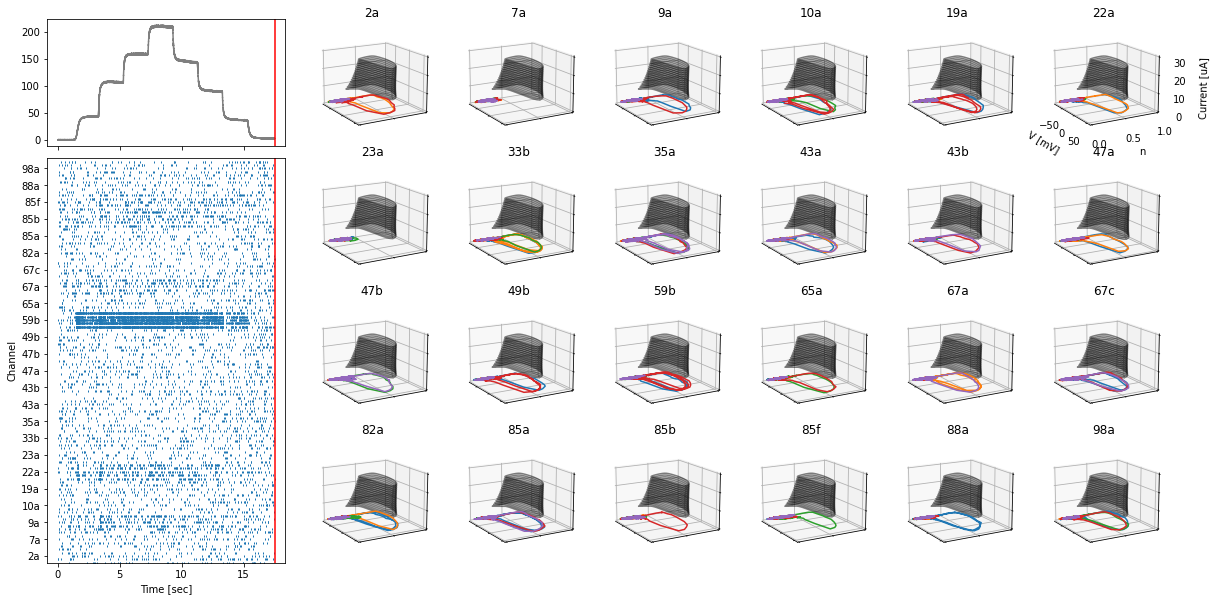

In [ ]:
%matplotlib inline
ds = 10
framerate = 60
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20,10))
gs = GridSpec(4,7,figure=fig, width_ratios=[2] + [1]*6, hspace=.1)
axes3d = np.empty((4,6), dtype=object)
ax_inp = fig.add_subplot(gs[0,0])
ax_inp.set(xticklabels=[])
ax_res = fig.add_subplot(gs[1:,0])

for i in range(4):
    for j in range(6):
        ax = axes3d[i,j] = fig.add_subplot(gs[i,j+1], projection='3d')
        for current, lc in limitcycles.items():
            _ = ax.plot(lc['v'],lc['n'], current, c='k', alpha=.5)
        ax.set(zlim=[0,30], ylim=[0,1], title=df_aff.columns[i*6+j])
        if i==0 and j==5:
            ax.set(xlabel='V [mV]', ylabel='n', zlabel='Current [uA]')
        else:
            ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.view_init(azim=-30, elev=15)

t_idx, n_idx = np.where(csn_neuron_1_pn.recorder.spike.T)
ax_res.plot(
    t_long[t_idx], n_idx, '|', markersize=2
)
ax_res.set(
    yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), 
    yticklabels=df_aff.columns, xlabel='Time [sec]', ylabel='Channel', 
    ylim=[0, N_r*N_pn]
)

t_span = .2 # 200 ms
t_plot = t_span
ax_inp.plot(t, stim, c='k', alpha=.5)
t_line = ax_inp.axvline(t_plot, color='r')
t_line_2 = ax_res.axvline(t_plot, color='r')


# channel_cs = plt.cm.get_cmap('viridis', N_r*N_pn)

lines = np.empty((N_r, N_pn), dtype=object)
for i, (_I, v, n) in enumerate(zip(pn_inp_I_long, csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1)), csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1)))):
    row, col = i // 6, i % 6
    ax = axes3d[row, col]
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    for m in range(N_pn):
        lines[i, m], = ax.plot(
            v[m, t_mask][::ds], n[m, t_mask][::ds], _I[t_mask][::ds], 
            # c=channel_cs(i*N_pn + m)
        )

t_plot_all = np.linspace(t_plot, t.max(), int(np.round(t_long.max() * framerate)))
state_v, state_n = csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1)), csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1))
for n, t_plot in tqdm(enumerate(t_plot_all), total=len(t_plot_all)):
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    _v, _n, _I  = state_v[..., t_mask][..., ::ds], state_n[..., t_mask][..., ::ds], pn_inp_I_long[:, t_mask][:, ::ds]
    for c in range(N_r):
        for p in range(N_pn):
            lines[c,p].set_data(_v[c,p], _n[c,p])
            lines[c,p].set_3d_properties(_I[c])
            # graph._offsets3d = (data.x, data.y, data.z)
            # dots[c].set_data(_v[c,[-1]], _n[c,[-1]])
            # dots[c].set_3d_properties(_I[c, [-1]])
            # dots[c]._offsets3d = (_v[c,-1], _n[c,-1], _I[c,-1])
            # dots[c].set_3d_properties(_I[c,-1])
    t_line.set_xdata(t_plot)
    t_line_2.set_xdata(t_plot)
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.savefig(f'video_frames_split_1/{n}.png')

In [ ]:
!tar cvzf mountain_frames_split_1.tar.gz video_frames_split_1/*.png

video_frames_split_1/0.png
video_frames_split_1/1000.png
video_frames_split_1/1001.png
video_frames_split_1/1002.png
video_frames_split_1/1003.png
video_frames_split_1/1004.png
video_frames_split_1/1005.png
video_frames_split_1/1006.png
video_frames_split_1/1007.png
video_frames_split_1/1008.png
video_frames_split_1/1009.png
video_frames_split_1/100.png
video_frames_split_1/1010.png
video_frames_split_1/1011.png
video_frames_split_1/1012.png
video_frames_split_1/1013.png
video_frames_split_1/1014.png
video_frames_split_1/1015.png
video_frames_split_1/1016.png
video_frames_split_1/1017.png
video_frames_split_1/1018.png
video_frames_split_1/1019.png
video_frames_split_1/101.png
video_frames_split_1/1020.png
video_frames_split_1/1021.png
video_frames_split_1/1022.png
video_frames_split_1/1023.png
video_frames_split_1/1024.png
video_frames_split_1/1025.png
video_frames_split_1/1026.png
video_frames_split_1/1027.png
video_frames_split_1/1028.png
video_frames_split_1/1029.png
video_frames_sp

### PN Current Simulations - 1-Pentanol

In [226]:
pn_inp_I = nn_rate_2.containers['PN-Dendrite'].recorder.output

NameError: name 'nn_rate_2' is not defined

In [228]:
N_pn = 5

In [ ]:
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), 1e-5)
pn_inp_I_long = np.vstack([np.interp(t_long, t, _I) for _I in pn_inp_I])
pn_inp_I_long_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I_long.T))

In [ ]:
nn_pn = Network()
csn_inp = nn_pn.input(num=N_r)
csn_rep = nn_pn.add(Repeat, num=N_r, rep_size=N_pn)
csn_neuron_0_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_r*N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_0_pn(I=csn_rep.output)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_0_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_long_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

### PN Trajectory Over LC Mountain - 1-Pentanol

Text(0.5, 0.98, 'Comparison of PN Spike Train for Noise-free/Noisy PN BSG Models - 1-Pentanol')

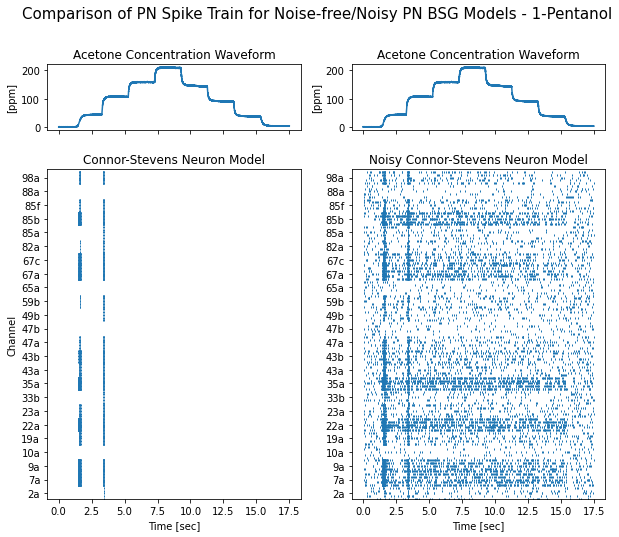

In [ ]:
%matplotlib inline
fig,axes = plt.subplots(2,2,figsize=(10,8), sharex=True, gridspec_kw=dict(height_ratios=[1,5]))
axes[0,0].plot(t, stim)
axes[0,1].plot(t, stim)
t_idx, n_idx = np.where(csn_neuron_0_pn.recorder.spike.T)
axes[1,0].plot(t_long[t_idx], n_idx, '|', markersize=2)
t_idx, n_idx = np.where(csn_neuron_1_pn.recorder.spike.T)
axes[1,1].plot(t_long[t_idx], n_idx, '|', markersize=2)
_ = axes[1,0].set(yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), yticklabels=df_aff.columns, xlabel='Time [sec]', ylabel='Channel', ylim=[0, N_r*N_pn], title='Connor-Stevens Neuron Model',)
_ = axes[1,1].set(yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), yticklabels=df_aff.columns, xlabel='Time [sec]', ylim=[0, N_r*N_pn], title='Noisy Connor-Stevens Neuron Model',)
axes[0,0].set( ylabel='[ppm]', title='Acetone Concentration Waveform')
axes[0,1].set( ylabel='[ppm]', title='Acetone Concentration Waveform')
fig.suptitle('Comparison of PN Spike Train for Noise-free/Noisy PN BSG Models - 1-Pentanol', fontsize=15)

  0%|          | 0/1050 [00:00<?, ?it/s]

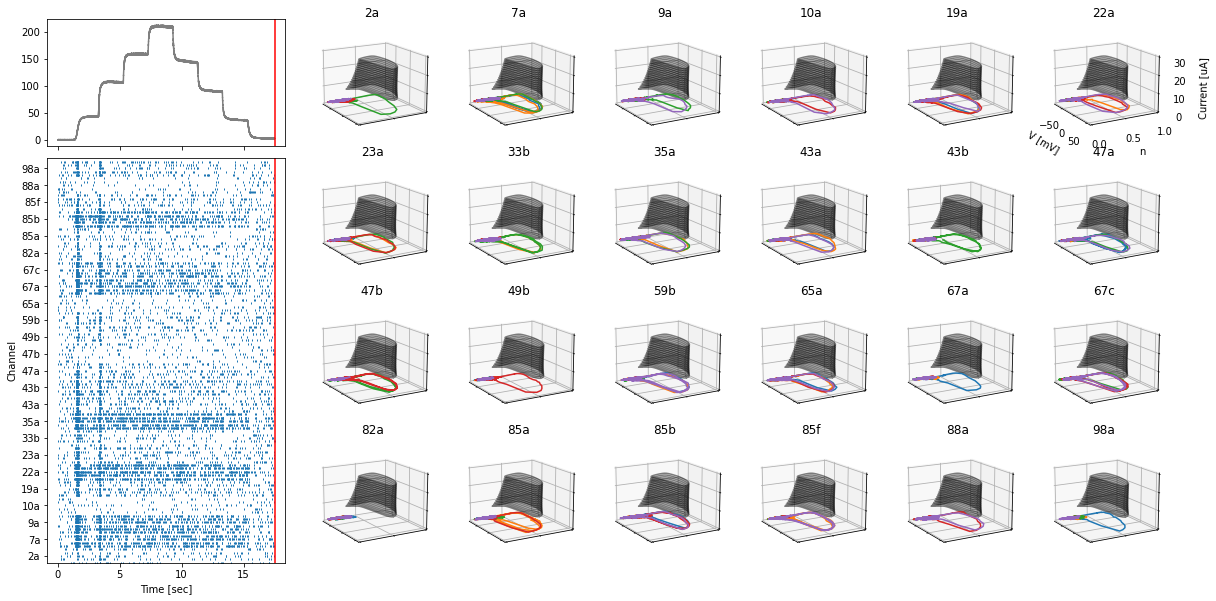

In [ ]:
%matplotlib inline
ds = 10
framerate = 60
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20,10))
gs = GridSpec(4,7,figure=fig, width_ratios=[2] + [1]*6, hspace=.1)
axes3d = np.empty((4,6), dtype=object)
ax_inp = fig.add_subplot(gs[0,0])
ax_inp.set(xticklabels=[])
ax_res = fig.add_subplot(gs[1:,0])

for i in range(4):
    for j in range(6):
        ax = axes3d[i,j] = fig.add_subplot(gs[i,j+1], projection='3d')
        for current, lc in limitcycles.items():
            _ = ax.plot(lc['v'],lc['n'], current, c='k', alpha=.5)
        ax.set(zlim=[0,30], ylim=[0,1], title=df_aff.columns[i*6+j])
        if i==0 and j==5:
            ax.set(xlabel='V [mV]', ylabel='n', zlabel='Current [uA]')
        else:
            ax.set(xticklabels=[], yticklabels=[], zticklabels=[])
        ax.view_init(azim=-30, elev=15)

t_idx, n_idx = np.where(csn_neuron_1_pn.recorder.spike.T)
ax_res.plot(
    t_long[t_idx], n_idx, '|', markersize=2
)
ax_res.set(
    yticks=np.arange(N_pn//2, N_r*N_pn+N_pn//2, N_pn), 
    yticklabels=df_aff.columns, xlabel='Time [sec]', ylabel='Channel', 
    ylim=[0, N_r*N_pn]
)

t_span = .2 # 200 ms
t_plot = t_span
ax_inp.plot(t, stim, c='k', alpha=.5)
t_line = ax_inp.axvline(t_plot, color='r')
t_line_2 = ax_res.axvline(t_plot, color='r')


# channel_cs = plt.cm.get_cmap('viridis', N_r*N_pn)

lines = np.empty((N_r, N_pn), dtype=object)
for i, (_I, v, n) in enumerate(zip(pn_inp_I_long, csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1)), csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1)))):
    row, col = i // 6, i % 6
    ax = axes3d[row, col]
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    for m in range(N_pn):
        lines[i, m], = ax.plot(
            v[m, t_mask][::ds], n[m, t_mask][::ds], _I[t_mask][::ds], 
            # c=channel_cs(i*N_pn + m)
        )

t_plot_all = np.linspace(t_plot, t.max(), int(np.round(t_long.max() * framerate)))
state_v, state_n = csn_neuron_1_pn.recorder.v.reshape((N_r, N_pn, -1)), csn_neuron_1_pn.recorder.n.reshape((N_r, N_pn, -1))
for n, t_plot in tqdm(enumerate(t_plot_all), total=len(t_plot_all)):
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    _v, _n, _I  = state_v[..., t_mask][..., ::ds], state_n[..., t_mask][..., ::ds], pn_inp_I_long[:, t_mask][:, ::ds]
    for c in range(N_r):
        for p in range(N_pn):
            lines[c,p].set_data(_v[c,p], _n[c,p])
            lines[c,p].set_3d_properties(_I[c])
            # graph._offsets3d = (data.x, data.y, data.z)
            # dots[c].set_data(_v[c,[-1]], _n[c,[-1]])
            # dots[c].set_3d_properties(_I[c, [-1]])
            # dots[c]._offsets3d = (_v[c,-1], _n[c,-1], _I[c,-1])
            # dots[c].set_3d_properties(_I[c,-1])
    t_line.set_xdata(t_plot)
    t_line_2.set_xdata(t_plot)
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.savefig(f'video_frames_split_1_pentanol/{n}.png')

In [ ]:
!tar cvzf mountain_frames_split_1_pentanol.tar.gz video_frames_split_1_pentanol/*.png

video_frames_split_1_pentanol/0.png
video_frames_split_1_pentanol/1000.png
video_frames_split_1_pentanol/1001.png
video_frames_split_1_pentanol/1002.png
video_frames_split_1_pentanol/1003.png
video_frames_split_1_pentanol/1004.png
video_frames_split_1_pentanol/1005.png
video_frames_split_1_pentanol/1006.png
video_frames_split_1_pentanol/1007.png
video_frames_split_1_pentanol/1008.png
video_frames_split_1_pentanol/1009.png
video_frames_split_1_pentanol/100.png
video_frames_split_1_pentanol/1010.png
video_frames_split_1_pentanol/1011.png
video_frames_split_1_pentanol/1012.png
video_frames_split_1_pentanol/1013.png
video_frames_split_1_pentanol/1014.png
video_frames_split_1_pentanol/1015.png
video_frames_split_1_pentanol/1016.png
video_frames_split_1_pentanol/1017.png
video_frames_split_1_pentanol/1018.png
video_frames_split_1_pentanol/1019.png
video_frames_split_1_pentanol/101.png
video_frames_split_1_pentanol/1020.png
video_frames_split_1_pentanol/1021.png
video_frames_split_1_pentanol/

  0%|          | 0/525 [00:00<?, ?it/s]

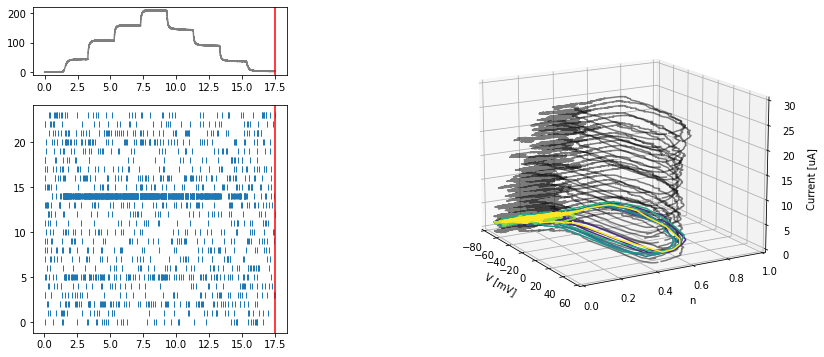

In [ ]:
%matplotlib inline
ds = 10
framerate = 30
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15,6))
gs = GridSpec(2,2,figure=fig, height_ratios=[1.5,5], width_ratios=[1.5,3])
ax = fig.add_subplot(gs[:,1], projection='3d')
ax_inp = fig.add_subplot(gs[0,0])
ax_res = fig.add_subplot(gs[1,0])
for current, lc in limitcycles.items():
    _ = ax.plot(lc['v'],lc['n'], current, c='k', alpha=.5)
ax.set(zlim=[0,30], ylim=[0,1], xlabel='V [mV]', ylabel='n', zlabel='Current [uA]')
ax.view_init(azim=-30, elev=15)

t_idx, n_idx = np.where(csn_neuron_1_pn.recorder.spike.T)
ax_res.plot(
    t_long[t_idx], n_idx, '|'
)

t_span = .2 # 200 ms
t_plot = t_span
ax_inp.plot(t, stim, c='k', alpha=.5)
t_line = ax_inp.axvline(t_plot, color='r')
t_line_2 = ax_res.axvline(t_plot, color='r')

t_plot_all = np.linspace(t_plot, t.max(), int(np.round(t_long.max() * framerate)))

lines = [None]*N_r
dots = [None]*N_r
for i, (_I, v, n) in enumerate(zip(pn_inp_I_long, csn_neuron.recorder.v, csn_neuron.recorder.n)):
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    lines[i], = ax.plot(v[t_mask][::ds], n[t_mask][::ds], _I[t_mask][::ds], c=channel_cs(i))
    dots[i], = ax.plot(v[t_mask][-1], n[t_mask][-1], _I[t_mask][-1], c=channel_cs(i), linestyle="", marker="o")

# for n, t_plot in tqdm(enumerate(t_plot_all), total=len(t_plot_all)):
#     t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
#     _v, _n, _I  = csn_neuron.recorder.v[:, t_mask][:, ::ds], csn_neuron.recorder.n[:, t_mask][:, ::ds], pn_inp_I_long[:, t_mask][:, ::ds]
#     for c in range(N_r):
#         lines[c].set_data(_v[c], _n[c])
#         lines[c].set_3d_properties(_I[c])
#         # graph._offsets3d = (data.x, data.y, data.z)
#         dots[c].set_data(_v[c,[-1]], _n[c,[-1]])
#         dots[c].set_3d_properties(_I[c, [-1]])
#         # dots[c]._offsets3d = (_v[c,-1], _n[c,-1], _I[c,-1])
#         # dots[c].set_3d_properties(_I[c,-1])
#     t_line.set_xdata(t_plot)
#     t_line_2.set_xdata(t_plot)
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     fig.savefig(f'video_frames_1/{n}.png')

In [ ]:
%matplotlib inline
ds = 10
framerate = 30
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15,6))
gs = GridSpec(2,2,figure=fig, height_ratios=[1.5,5], width_ratios=[1.5,3])
ax = fig.add_subplot(gs[:,1], projection='3d')
ax_inp = fig.add_subplot(gs[0,0])
ax_res = fig.add_subplot(gs[1,0])
for current, lc in limitcycles.items():
    _ = ax.plot(lc['v'],lc['n'], current, c='k', alpha=.5)
ax.set(zlim=[0,30], ylim=[0,1], xlabel='V [mV]', ylabel='n', zlabel='Current [uA]')
ax.view_init(azim=-30, elev=15)

ax_res.plot(
    t_long[t_idx], n_idx, '|'
)
channel_cs = plt.cm.get_cmap('viridis', N_r)

t_span = .2 # 200 ms
t_plot = t_span
ax_inp.plot(t, stim, c='k', alpha=.5)
t_line = ax_inp.axvline(t_plot, color='r')
t_line_2 = ax_res.axvline(t_plot, color='r')

t_plot_all = np.linspace(t_plot, t.max(), int(np.round(t_long.max() * framerate)))

lines = [None]*N_r
dots = [None]*N_r
for i, (_I, v, n) in enumerate(zip(pn_inp_I_long, csn_neuron.recorder.v, csn_neuron.recorder.n)):
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    lines[i], = ax.plot(v[t_mask][::ds], n[t_mask][::ds], _I[t_mask][::ds], c=channel_cs(i))
    dots[i], = ax.plot(v[t_mask][-1], n[t_mask][-1], _I[t_mask][-1], c=channel_cs(i), linestyle="", marker="o")

for n, t_plot in tqdm(enumerate(t_plot_all), total=len(t_plot_all)):
    t_mask = np.logical_and(t_long >= max(0, t_plot-t_span), t_long<=t_plot)
    _v, _n, _I  = csn_neuron.recorder.v[:, t_mask][:, ::ds], csn_neuron.recorder.n[:, t_mask][:, ::ds], pn_inp_I_long[:, t_mask][:, ::ds]
    for c in range(N_r):
        lines[c].set_data(_v[c], _n[c])
        lines[c].set_3d_properties(_I[c])
        # graph._offsets3d = (data.x, data.y, data.z)
        dots[c].set_data(_v[c,[-1]], _n[c,[-1]])
        dots[c].set_3d_properties(_I[c, [-1]])
        # dots[c]._offsets3d = (_v[c,-1], _n[c,-1], _I[c,-1])
        # dots[c].set_3d_properties(_I[c,-1])
    t_line.set_xdata(t_plot)
    t_line_2.set_xdata(t_plot)
    fig.canvas.draw()
    fig.canvas.flush_events()
    fig.savefig(f'video_frames_1/{n}.png')

In [ ]:
!tar czvf mountain_frames_1.tar.gz video_frames_1/*.png

video_frames_1/0.png
video_frames_1/100.png
video_frames_1/101.png
video_frames_1/102.png
video_frames_1/103.png
video_frames_1/104.png
video_frames_1/105.png
video_frames_1/106.png
video_frames_1/107.png
video_frames_1/108.png
video_frames_1/109.png
video_frames_1/10.png
video_frames_1/110.png
video_frames_1/111.png
video_frames_1/112.png
video_frames_1/113.png
video_frames_1/114.png
video_frames_1/115.png
video_frames_1/116.png
video_frames_1/117.png
video_frames_1/118.png
video_frames_1/119.png
video_frames_1/11.png
video_frames_1/120.png
video_frames_1/121.png
video_frames_1/122.png
video_frames_1/123.png
video_frames_1/124.png
video_frames_1/125.png
video_frames_1/126.png
video_frames_1/127.png
video_frames_1/128.png
video_frames_1/129.png
video_frames_1/12.png
video_frames_1/130.png
video_frames_1/131.png
video_frames_1/132.png
video_frames_1/133.png
video_frames_1/134.png
video_frames_1/135.png
video_frames_1/136.png
video_frames_1/137.png
video_frames_1/138.png
video_frames_1/1

## Spiking Model

In [73]:
np.load('pn_inp.npz').keys()

['I', 't']

In [4]:
pn_inp_I = np.load('2channel_data.npz')['I']
pn_out_x = np.load('2channel_data.npz')['x']

In [9]:
dt=1e-4
t = np.arange(pn_out_x.shape[1])*dt

In [10]:
N_pn = 10
N_inp = len(pn_inp_I)

In [11]:
dt_long = 1e-5
t_long = np.arange(t.min(), t.max(), 1e-5)
pn_inp_I_long = np.vstack([np.interp(t_long, t, _I) for _I in pn_inp_I])
pn_inp_I_long_g = garray.to_gpu(np.ascontiguousarray(pn_inp_I_long.T))

In [12]:
nn_pn = Network()
csn_inp = nn_pn.input(num=N_inp)
csn_rep = nn_pn.add(Repeat, num=N_inp, rep_size=N_pn)
csn_neuron_0_pn = nn_pn.add(NoisyConnorStevens, num=N_inp*N_pn, sigma=0)
csn_neuron_1_pn = nn_pn.add(NoisyConnorStevens, num=N_inp*N_pn, sigma=0.0014/np.sqrt(dt_long))
csn_rep(input=csn_inp)
csn_neuron_0_pn(I=csn_rep.output)
csn_neuron_1_pn(I=csn_rep.output)
nn_pn.compile()
csn_neuron_0_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_neuron_1_pn.record('spike', 'v', 'n', 'm', 'h', 'a', 'b')
csn_inp(pn_inp_I_long_g)
nn_pn.run(dt_long, verbose=True)

  0%|          | 0/1749990 [00:00<?, ?it/s]

In [13]:
from neural.utils import compute_psth

In [14]:
psth, psth_t = compute_psth(csn_neuron_1_pn.recorder.spike.reshape((N_inp ,N_pn, -1))[0], dt_long, .2, .1)

In [15]:
df_aff = pd.read_csv('../data/estimated_affinity.csv', index_col=0)
data = np.load('../data/staircase.npz', allow_pickle=True)
t = data['t']
stim = data['pn_input'][2]


In [17]:
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()

<ipython-input-23-b9fae14b77a5>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[0,2]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)


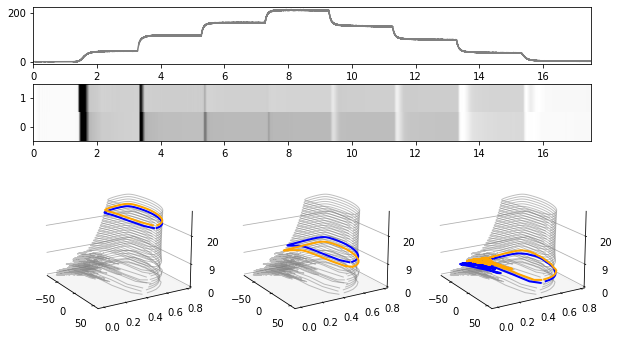

In [23]:
%matplotlib inline
fig = plt.figure(figsize=(10,6))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1,1,3])
ax_inp = fig.add_subplot(gs[0,:])
ax_rate = fig.add_subplot(gs[1,:], sharex=ax_inp)
ax_inp.plot(t, stim, color='grey')
ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[0,2]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)

ax_3d = [
    fig.add_subplot(gs[2,0], projection='3d'),
    fig.add_subplot(gs[2,1], projection='3d'),
    fig.add_subplot(gs[2,2], projection='3d'),
]



for i, ax in enumerate(ax_3d):
    norm = mpl.colors.CenteredNorm(vcenter=9)
    for I in range(0, 30):
        c = 'grey'
        lw=1
        alpha=.5
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)


    ax.set(zticks=[0,9,20,30])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.zaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    ax.view_init(azim=-31, elev=18)
    
t_plot=[1.6, 8.6, 13.6]
for i, (_t, ax) in enumerate(zip(t_plot, ax_3d)):
    t_idx = int(_t // 1e-4)
    I1 = np.ceil(pn_inp_I[0, t_idx])
    I2 = np.ceil(pn_inp_I[2, t_idx])
    for I, c in zip([I1, I2], ['blue', 'orange']):
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=2, alpha=1)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=2, alpha=1)
fig.savefig('or59b_comparison_3d.pdf')

<ipython-input-24-411b41998c82>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[1,3]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)


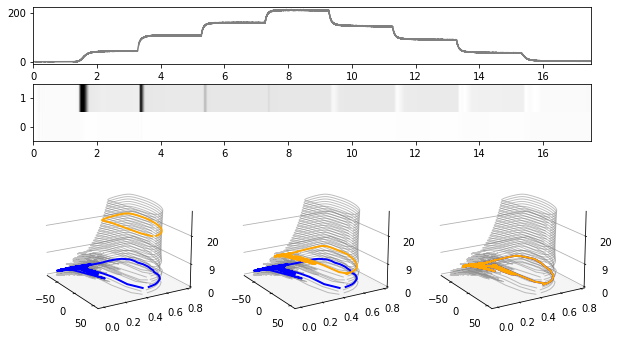

In [24]:
%matplotlib inline
fig = plt.figure(figsize=(10,6))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1,1,3])
ax_inp = fig.add_subplot(gs[0,:])
ax_rate = fig.add_subplot(gs[1,:], sharex=ax_inp)
ax_inp.plot(t, stim, color='grey')
ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[1,3]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)

ax_3d = [
    fig.add_subplot(gs[2,0], projection='3d'),
    fig.add_subplot(gs[2,1], projection='3d'),
    fig.add_subplot(gs[2,2], projection='3d'),
]



for i, ax in enumerate(ax_3d):
    norm = mpl.colors.CenteredNorm(vcenter=9)
    for I in range(0, 30):
        c = 'grey'
        lw=1
        alpha=.5
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)


    ax.set(zticks=[0,9,20,30])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.zaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    ax.view_init(azim=-31, elev=18)
    
t_plot=[1.6, 8.6, 13.6]
for i, (_t, ax) in enumerate(zip(t_plot, ax_3d)):
    t_idx = int(_t // 1e-4)
    I1 = np.ceil(pn_inp_I[1, t_idx])
    I2 = np.ceil(pn_inp_I[3, t_idx])
    for I, c in zip([I1, I2], ['blue', 'orange']):
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=2, alpha=1)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=2, alpha=1)
fig.savefig('or43b_comparison_3d.pdf')

<ipython-input-55-d90b80f37b20>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[0,2]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)


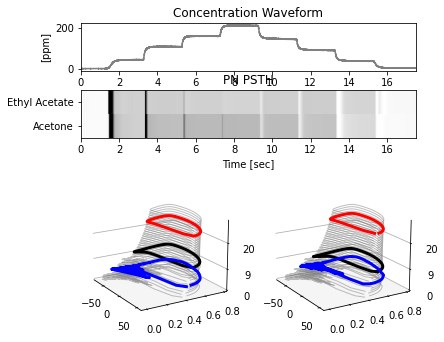

In [55]:
%matplotlib inline
fig = plt.figure(figsize=(6,6))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1,1,4])
ax_inp = fig.add_subplot(gs[0,:])
ax_rate = fig.add_subplot(gs[1,:], sharex=ax_inp)
ax_inp.plot(t, stim, color='grey')
ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[0,2]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)
ax_rate.set(yticks=[0,1], yticklabels=['Acetone', 'Ethyl Acetate'], title='PN PSTH', xlabel='Time [sec]')
ax_inp.set(ylabel='[ppm]', title='Concentration Waveform')

ax_3d = [
    fig.add_subplot(gs[2,0], projection='3d'),
    fig.add_subplot(gs[2,1], projection='3d'),
]



for i, ax in enumerate(ax_3d):
    norm = mpl.colors.CenteredNorm(vcenter=9)
    for I in range(0, 30):
        c = 'grey'
        lw=1
        alpha=.5
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)


    ax.set(zticks=[0,9,20,30])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.zaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    ax.view_init(azim=-31, elev=18)
    
t_plot=[1.6, 8.6, 13.6]
for n_idx, ax in zip([0,2], ax_3d):
    for i, (_t, c) in enumerate(zip(t_plot, ['red', 'black', 'blue'])):
        t_idx = int(_t // 1e-4)
        I = np.ceil(pn_inp_I[n_idx, t_idx])
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=3, alpha=1)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=3, alpha=1)
fig.savefig('or59b_comparison_3d.pdf')

<ipython-input-56-9b2be5e610ee>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[1,3]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)


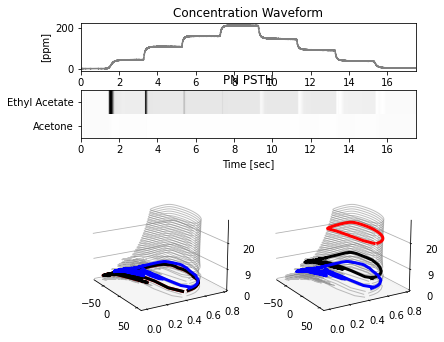

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(6,6))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1,1,4])
ax_inp = fig.add_subplot(gs[0,:])
ax_rate = fig.add_subplot(gs[1,:], sharex=ax_inp)
ax_inp.plot(t, stim, color='grey')
ax_rate.pcolormesh(t, [-.5, .5, 1.5], pn_out_x[[1,3]]/1e-4, cmap=plt.cm.Greys, vmin=0, vmax=120, rasterized=True)
ax_rate.set(yticks=[0,1], yticklabels=['Acetone', 'Ethyl Acetate'], title='PN PSTH', xlabel='Time [sec]')
ax_inp.set(ylabel='[ppm]', title='Concentration Waveform')

ax_3d = [
    fig.add_subplot(gs[2,0], projection='3d'),
    fig.add_subplot(gs[2,1], projection='3d'),
]



for i, ax in enumerate(ax_3d):
    norm = mpl.colors.CenteredNorm(vcenter=9)
    for I in range(0, 30):
        c = 'grey'
        lw=1
        alpha=.5
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=lw, alpha=alpha)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=lw, alpha=alpha)


    ax.set(zticks=[0,9,20,30])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    # for tick in ax.xaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.yaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    # for tick in ax.zaxis.get_major_ticks():
    #     tick.label.set_fontsize(15) 
    ax.view_init(azim=-31, elev=18)
    
t_plot=[1.6, 8.6, 13.6]
for n_idx, ax in zip([1,3], ax_3d):
    for i, (_t, c) in enumerate(zip(t_plot, ['red', 'black', 'blue'])):
        t_idx = int(_t // 1e-4)
        I = np.ceil(pn_inp_I[n_idx, t_idx])
        if I in lc_clean:
            v,n =lc_clean[I]['v'][::5], lc_clean[I]['n'][::5]
            ax.plot(v, n, np.ones_like(v)*I, c=c, lw=3, alpha=1)
        elif I in lc_noisy:
            v,n = lc_noisy[I]['v'][::5], lc_noisy[I]['n'][::5]
            ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c=c, lw=3, alpha=1)
fig.savefig('or43b_comparison_3d.pdf')

(1.3, 2.0)

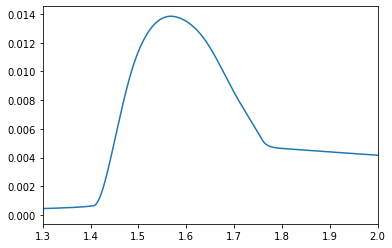

In [43]:
plt.plot(t, pn_out_x[0])
plt.xlim([1.3, 2])

In [54]:
%matplotlib widget
mask = np.logical_and(t>=1.3, t<=1.9)
mask_2 = np.logical_and(t_long[::10]>=1.3, t_long[::10]<=1.9)
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection='3d'))
ax.plot(
    csn_neuron_1_pn.recorder.v[0, ::10][mask_2],
    csn_neuron_1_pn.recorder.n[0, ::10][mask_2],
    pn_inp_I[0][mask]
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

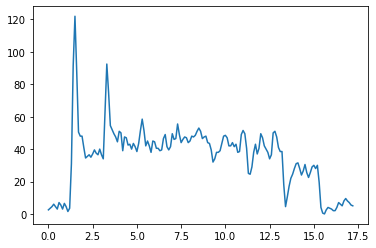

In [50]:
plt.plot(psth_t, psth)

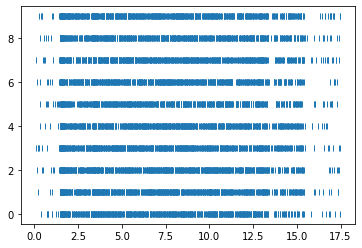

In [42]:
%matplotlib inline
n_idx, t_idx = np.where(csn_neuron_1_pn.recorder.spike.reshape((N_inp ,N_pn, -1))[0])
plt.figure()
plt.plot(t_long[t_idx], n_idx, '|')

In [19]:
%matplotlib widget
lc_noisy = np.load('lc_full_noisy.npz', allow_pickle=True)['arr_0'].item()
lc_clean = np.load('lc_full.npz', allow_pickle=True)['arr_0'].item()
fig,ax = plt.subplots(1,1,figsize=(8,8),subplot_kw=dict(projection='3d'))
norm = mpl.colors.CenteredNorm(vcenter=9)
for I in range(0, 30):
    if I in lc_clean:
        v,n =lc_clean[I]['v'], lc_clean[I]['n']
        ax.plot(v, n, np.ones_like(v)*I, c='grey', alpha=.5)
    elif I in lc_noisy:
        v,n = lc_noisy[I]['v'], lc_noisy[I]['n']
        ax.plot(v[~v.mask], n[~v.mask], np.ones_like(v[~v.mask])*I, c='grey', alpha=.5)


ax.set(zticks=[0,9,20,30])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax_2d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax.view_init(azim=-31, elev=18)

nn.containers['PN-BSG'].recorder.x[14]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

TypeError: plot() missing 2 required positional arguments: 'xs' and 'ys'